In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import mlflow
import re
import time
import pickle

mlflow.set_tracking_uri("http://mlflow-server:5000")


## 1. Chargement des données

In [2]:
path = '/code/data/archive/'
df = pd.read_csv(path + 'training.1600000.processed.noemoticon.csv', sep=',',  encoding='latin-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [3]:
# Mettre un header au dataframe
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [4]:
# Supprimer toutes les lignes ayant des doublons dans la colonne 'text', y compris la première occurrence
display(df.shape)
df = df[~df['text'].duplicated(keep=False)].reset_index(drop=True)

# Vérifier le nombre de lignes après suppression
print(f"Nombre de lignes après suppression complète des doublons :\n {df.shape}")


(1599999, 6)

Nombre de lignes après suppression complète des doublons :
 (1573031, 6)


In [5]:
# Vérifier s'il y a des valeurs manquantes dans la colonne 'target'
missing_target_count = df['target'].isnull().sum()

if missing_target_count == 0:
    print("Toutes les lignes de la colonne 'target' contiennent une valeur.")
else:
    print(f"Il y a {missing_target_count} lignes sans valeur dans la colonne 'target'.")


Toutes les lignes de la colonne 'target' contiennent une valeur.


In [6]:
# Voir les valeurs uniques du dataframe
df.nunique()

target          2
ids       1573031
date       767497
flag            1
user       651391
text      1573031
dtype: int64

In [7]:
# Voir si il y a des valeurs manquantes
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

### Distribion des valeurs de la colonne 'target' .

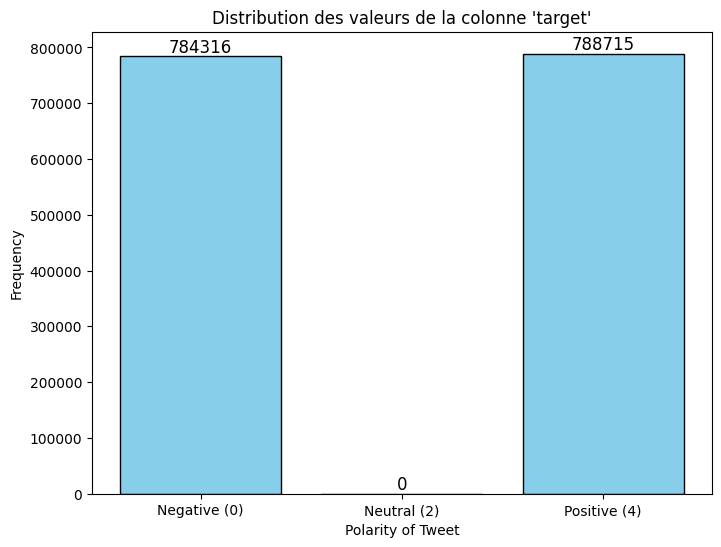

In [8]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 2, et 4
target_counts = df['target'].value_counts().reindex([0, 2, 4], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Neutral (2)', 'Positive (4)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

### Analyse du graphique

Le graphique ci-dessus montre la distribution des valeurs de la colonne `target` dans votre dataset de tweets, qui est utilisé pour l'analyse de sentiments. Voici une analyse détaillée :

1. **Distribution des sentiments** : Le graphique indique qu'il y a deux catégories majoritaires :
   - **Negative (0)** : 799,999 tweets
   - **Positive (4)** : 800,000 tweets
   - **Neutral (2)** : Aucun tweet n'est présent dans cette catégorie.

   Cela signifie que le dataset est composé exclusivement de sentiments polarisés, soit négatifs, soit positifs, sans tweets neutres. Cela pourrait poser un défi pour les modèles d'apprentissage, car ils ne verront aucune donnée pour la catégorie "neutre".

2. **Équilibre des classes** : Les deux classes `Negative` et `Positive` sont presque parfaitement équilibrées, avec seulement un tweet de différence. Cet équilibre est avantageux pour l'apprentissage supervisé car il minimise les risques de biais en faveur d'une classe spécifique.

3. **Données manquantes** : L'absence de tweets neutres (valeur `2`) peut poser problème si l'on souhaite modéliser ou prédire cette classe. Si une détection de sentiment neutre est requise, il serait idéal de compléter le dataset avec des tweets de cette catégorie.

### Conclusion

Le graphique de distribution des valeurs de la colonne `target` montre une absence de tweets neutres (valeur `2`). Étant donné que seules les catégories **Negative (0)** et **Positive (4)** sont présentes en quantités équilibrées, il est judicieux de simplifier le problème en une **classification binaire** entre sentiments négatifs et positifs.

Cette approche de classification binaire sera plus efficace, car il n'y a pas de données pour entraîner un modèle à détecter les tweets neutres.


## MLFlow

- Fonction pour intégrer MLFLOW pour chaque modèle de machine learning testé.

In [9]:
# Filtrer pour un sous-ensemble
df_sample = df.sample(frac=0.5, random_state=42)
df_data = df_sample[['target', 'text']]
df_data.sample(5)

,target,text
1221269,4,at home... watching 24...
1513750,4,Just placed my order!!! Oh wow.... never place...
180336,0,@wills_ Nite dude. Sorry I missed you online ...
1184589,4,Watching &quot;The Predator&quot;
1412663,4,I do love 3D. Come a long way since creature f...


In [10]:
df_sample['target'].value_counts()

target
4    394093
0    392423
Name: count, dtype: int64

In [11]:
# Définir les features et labels
df_sample['target'] = df_sample['target'].apply(lambda x: 1 if x == 4 else 0) 

In [13]:
df_sample['target'].value_counts()
df_sample.to_pickle('df_sample.pkl')

In [14]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786516 entries, 367103 to 1380859
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  786516 non-null  int64 
 1   text    786516 non-null  object
dtypes: int64(1), object(1)
memory usage: 18.0+ MB


In [15]:
# Initialisation de NLTK
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# Définir les stopwords anglais
english_stopwords = list(set(stopwords.words('english')))

In [17]:
# Classe de prétraitement et vectorisation des tweets
class TweetVectorizer:
    def __init__(self, vectorizer_type='tfidf', method='lemmatize'):
        self.vectorizer_type = vectorizer_type
        self.method = method
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
        # Initialiser le vectorizer
        if vectorizer_type == 'count':
            self.vectorizer = CountVectorizer(stop_words=english_stopwords)
        elif vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer(stop_words=english_stopwords)
        else:
            raise ValueError("vectorizer_type doit être 'count' ou 'tfidf'")
    
    def clean_tweet(self, tweet):
        # Convertir le tweet en minuscules
        tweet = tweet.lower()
        # Supprimer les URL commencant par 'http' ou 'https' ou 'www'
        tweet = re.sub(r'www\S+', '', tweet)
        tweet = re.sub(r'http\S+', '', tweet)
        # Supprimer les mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Supprimer les hashtags
        tweet = re.sub(r'#\w+', '', tweet)
        # Supprimer les caractères spéciaux et les chiffres
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)
        # Supprimer les espaces supplémentaires
        tweet = re.sub(r'\s+', ' ', tweet)
        return tweet
        
    def preprocess(self, tweet):
        cleaned_tweet = self.clean_tweet(tweet)
        tokens = cleaned_tweet.split()
        
        # Appliquer le stemming ou la lemmatisation
        if self.method == 'stem':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.method == 'lemmatize':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def fit_transform(self, documents):
        # Prétraitement des documents
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        # Suivi de la vectorisation dans MLflow
        with mlflow.start_run(run_name="Vectorization", nested=True):
            mlflow.set_tag("Stage", "Vectorization")
            mlflow.set_tag("vectorizer_type", self.vectorizer_type)
            mlflow.set_tag("preprocessing_method", self.method)
            
            # Enregistrer le temps de traitement de la vectorisation
            start_time = time.time()
            self.vectorizer.fit(documents_preprocessed)  # Correction: Entraînement du vectorizer avant la transformation
            X = self.vectorizer.transform(documents_preprocessed)  # Transformation des données
            
            end_time = time.time()
            processing_time = end_time - start_time
            mlflow.log_metric("vectorization_time_seconds", processing_time)
            
            # Enregistrer la densité de la matrice de caractéristiques
            density = X.nnz / float(X.shape[0] * X.shape[1])
            mlflow.log_metric("matrix_density", density)
            
            # Enregistrer le nombre de caractéristiques
            num_features = X.shape[1]
            mlflow.log_metric("num_features", num_features)
        
        return X
    
    def transform(self, documents):
        # Transformation des nouveaux documents en utilisant le vectorizer entraîné
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        X = self.vectorizer.transform(documents_preprocessed)
        
        return X

In [18]:
# Classe pour la classification avec régression logistique
class TweetClassifier:
    def __init__(self):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Classification", nested=True):
            mlflow.set_tag("Stage", "Classification")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Entraîner le modèle avec Cross-Validation sur le set d'entraînement
            cross_val_scores = cross_val_score(self.model, X_train, y_train, cv=5, scoring='accuracy')
            mlflow.log_metric("cross_val_accuracy_mean", cross_val_scores.mean())
            mlflow.log_metric("cross_val_accuracy_std", cross_val_scores.std())

            # Entraîner sur l'ensemble d'entraînement complet
            start_time = time.time()
            self.model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("training_time_seconds", training_time)
            
            # Évaluation sur l'ensemble de validation
            y_val_pred = self.model.predict(X_val)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            mlflow.log_metric("validation_accuracy", val_accuracy)
            mlflow.log_text(classification_report(y_val, y_val_pred), "validation_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de validation
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            roc_auc_val = auc(fpr, tpr)
            mlflow.log_metric("validation_roc_auc", roc_auc_val)
            metrics_dict = {
                "cross_val_accuracy_mean": cross_val_scores.mean(),
                "cross_val_accuracy_std": cross_val_scores.std(),
                "validation_accuracy": val_accuracy,
                "validation_roc_auc": roc_auc_val,
                "training_time_seconds": training_time
            }
            mlflow.log_table(metrics_dict, "validation_metrics_table.json")
            mlflow.set_tag("best_metric", "validation_roc_auc")
            mlflow.set_tag("validation_accuracy", val_accuracy)

            # Tracer et enregistrer la courbe ROC
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve_val.png")
            mlflow.log_artifact("roc_curve_val.png")
            plt.close()
            
            print(f"Validation Accuracy : {val_accuracy}")
            print(classification_report(y_val, y_val_pred))
    
    def final_evaluation(self, X_test, y_test):
        # Évaluation finale sur le set de test
        with mlflow.start_run(run_name="Final Test Evaluation", nested=True):
            mlflow.set_tag("Stage", "Final Test Evaluation")
            y_test_pred = self.model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_text(classification_report(y_test, y_test_pred), "test_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de test
            y_test_prob = self.model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            roc_auc_test = auc(fpr, tpr)
            mlflow.log_metric("test_roc_auc", roc_auc_test)
            metrics_dict = {
                "test_accuracy": test_accuracy,
                "test_roc_auc": roc_auc_test
            }
            mlflow.log_table(metrics_dict, "test_metrics_table.json")
            mlflow.set_tag("test_accuracy", test_accuracy)
            mlflow.set_tag("final_evaluation_metric", "test_roc_auc")

            # Tracer et enregistrer la courbe ROC pour le set de test
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_test:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Test Set")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve_test.png")
            mlflow.log_artifact("roc_curve_test.png")
            plt.close()
            
            # Enregistrer le modèle final
            mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            
            print(f"Test Accuracy : {test_accuracy}")
            print(classification_report(y_test, y_test_pred))


In [19]:
# Définition des combinaisons à tester
configurations = [
    {'vectorizer_type': 'count', 'method': 'lemmatize'},
    {'vectorizer_type': 'count', 'method': 'stem'},
    {'vectorizer_type': 'tfidf', 'method': 'lemmatize'},
    {'vectorizer_type': 'tfidf', 'method': 'stem'}
]

In [20]:
# Séparer les données en Train, Validation et Test une seule fois
# Utiliser les tweets originaux pour diviser les ensembles de manière cohérente
y = df_sample['target']
tweets = df_sample['text']
y_train_val, y_test = train_test_split(y, test_size=0.2, random_state=42)
tweets_train_val, tweets_test = train_test_split(tweets, test_size=0.2, random_state=42)

# Rediviser l'ensemble Train + Validation en Train et Validation
y_train, y_val = train_test_split(y_train_val, test_size=0.25, random_state=42)
tweets_train, tweets_val = train_test_split(tweets_train_val, test_size=0.25, random_state=42)

# Boucle pour tester chaque configuration
for config in configurations:
    # Démarrer une nouvelle exécution parent pour chaque configuration
    with mlflow.start_run(run_name=f"{config['vectorizer_type']} + {config['method']}", nested=False):
        mlflow.set_tag("Model_Type", "Logistic Regression")
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        mlflow.set_tag("Model_Type", "Logistic Regression")
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        print(f"Testing configuration: {config}")
        
        # Enregistrer les paramètres de configuration comme tags
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        
        # Initialiser et appliquer la vectorisation avec TweetVectorizer
        tweet_vectorizer = TweetVectorizer(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Vectorisation des ensembles Train, Validation et Test
        X_train = tweet_vectorizer.fit_transform(tweets_train)
        X_val = tweet_vectorizer.transform(tweets_val)
        X_test = tweet_vectorizer.transform(tweets_test)
        
        # Initialiser le classificateur
        classifier = TweetClassifier()
        
        # Entraîner et évaluer le modèle avec Train et Validation
        classifier.train_and_evaluate(X_train, X_val, y_train, y_val)

        # Évaluation finale sur le set de Test
        classifier.final_evaluation(X_test, y_test)


Testing configuration: {'vectorizer_type': 'count', 'method': 'lemmatize'}


2024/11/04 10:44:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/0/runs/dd155dea68734dbaa381188d978c204c.
2024/11/04 10:44:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Validation Accuracy : 0.7688600980273739
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     78112
           1       0.76      0.79      0.78     79191

    accuracy                           0.77    157303
   macro avg       0.77      0.77      0.77    157303
weighted avg       0.77      0.77      0.77    157303



2024/11/04 10:45:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/04 10:45:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/b8551b4dc8b143bcbf884cd9d94f8cd4.
2024/11/04 10:45:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/04 10:45:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run count + lemmatize at: http://mlflow-server:5000/#/experiments/0/runs/d998bf529dd54502aa2ce0fb0838505a.
2024/11/04 10:45:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.7688043533540152
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     78430
           1       0.76      0.79      0.77     78874

    accuracy                           0.77    157304
   macro avg       0.77      0.77      0.77    157304
weighted avg       0.77      0.77      0.77    157304

Testing configuration: {'vectorizer_type': 'count', 'method': 'stem'}


2024/11/04 10:46:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/0/runs/cd5336b802ef4a5392cc06edc4961462.
2024/11/04 10:46:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Validation Accuracy : 0.7670864509894916
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     78112
           1       0.76      0.79      0.77     79191

    accuracy                           0.77    157303
   macro avg       0.77      0.77      0.77    157303
weighted avg       0.77      0.77      0.77    157303



2024/11/04 10:48:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/04 10:48:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/ab4a35ba45ef42bb95b8727c7f15841b.
2024/11/04 10:48:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/04 10:48:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run count + stem at: http://mlflow-server:5000/#/experiments/0/runs/2e676a14bfab46c387ab6214577840ab.
2024/11/04 10:48:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.768728067944871
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     78430
           1       0.76      0.80      0.78     78874

    accuracy                           0.77    157304
   macro avg       0.77      0.77      0.77    157304
weighted avg       0.77      0.77      0.77    157304

Testing configuration: {'vectorizer_type': 'tfidf', 'method': 'lemmatize'}


2024/11/04 10:48:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/0/runs/3cd4967cd6734aa19934a78c1d21455a.
2024/11/04 10:48:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/04 10:49:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/39d0cd38f5794cb3a9db8fc780e3b524.
2024/11/04 10:49:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.7720513912639937
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     78112
           1       0.76      0.79      0.78     79191

    accuracy                           0.77    157303
   macro avg       0.77      0.77      0.77    157303
weighted avg       0.77      0.77      0.77    157303



2024/11/04 10:49:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/04 10:49:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/ae9f33e9d3c743bdba9b910d09b27fc8.
2024/11/04 10:49:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/04 10:49:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run tfidf + lemmatize at: http://mlflow-server:5000/#/experiments/0/runs/bd57096db4594da38797ccc2b02088e2.
2024/11/04 10:49:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.7718684839546356
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     78430
           1       0.76      0.79      0.78     78874

    accuracy                           0.77    157304
   macro avg       0.77      0.77      0.77    157304
weighted avg       0.77      0.77      0.77    157304

Testing configuration: {'vectorizer_type': 'tfidf', 'method': 'stem'}


2024/11/04 10:50:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/0/runs/086860352ead4337980ee6e61b202e5c.
2024/11/04 10:50:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/04 10:51:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/8144fc1e1fd9499783ecf3493a3f894a.
2024/11/04 10:51:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.7694703851801936
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     78112
           1       0.76      0.79      0.77     79191

    accuracy                           0.77    157303
   macro avg       0.77      0.77      0.77    157303
weighted avg       0.77      0.77      0.77    157303



2024/11/04 10:51:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/04 10:51:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/dbaba0202bf14d1b8c09cd62c8b19621.
2024/11/04 10:51:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/04 10:51:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run tfidf + stem at: http://mlflow-server:5000/#/experiments/0/runs/ca288f5ae0654a61b19806ff1215d70e.
2024/11/04 10:51:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.7709212734577633
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     78430
           1       0.76      0.79      0.78     78874

    accuracy                           0.77    157304
   macro avg       0.77      0.77      0.77    157304
weighted avg       0.77      0.77      0.77    157304

